In [1]:
import warnings

warnings.filterwarnings('ignore')

# Introduction to computational study of lithium ion battery
*Copyright (c) 2022 Institute for Quantum Computing, Baidu Inc. All Rights Reserved.*

Lithium ion battery is an efficient and long-lasting battery, it has been widely used in various consumer electronics, industrial devices and automotive power systems. The development of lithium ion battery has promoted the popularization of electric vehicles and provided strong support for storage of renewable energy. Due to the advantages of lithium batteries, such as being lightweight, having high energy density, and being environmentally friendly, they have a wide range of applications and a good industry development prospect. Currently, the industry of lithium ion battery is under rapid development and is continuously innovating and promoting new technologies.

The energy of lithium ion battery is generated by the electron-chemical interaction between its cathode and anode materials.
$$
LiC_6+CoO_2\stackrel{Discharge}{\underset{\text{Charge}}{\rightleftarrows}}6C+LiCoO_2.
$$

According to the thermodynamics, this energy equals the difference of free energy \[1\] between materials in cathode and anode, which can be approximated by their ground state energy difference\[2\].
$$
\Delta G=G_{\text{LiCoO}_2}+6G_{\text{C}}-G_{\text{CoO}_2}-G_{\text{LiC}_6}.
$$

Since the energy emitted during the chemical reaction is closely related to the molecules/materials occur in above formula, we have to obtain the accurate ground state energy of these molecules/materials once we want to estimate the total energy of the lithium ion battery. Meanwhile, the transport of lithium ion between the cathode and anode involves ion adsorption, which can be affected by the polarizability of related molecules.

## Calculate ground state properties of molecule by quantum computational chemistry
### Build molecular Hamiltonian
The Hamiltonian of molecule is determined by its geometry and composition. Though the underlying procedure is a little complicated, users can easily achieve it by using `paddle_quantum`'s `qchem` module.

In [3]:
from paddle_quantum.qchem import Molecule, PySCFDriver

mol = Molecule(
    geometry = [("H", [0.0, 0.0, 0.0]), ("H", [0.0, 0.0, 0.7])],
    driver = PySCFDriver()
)

Now we have built a hydrogen molecule model. In the code above, the `driver` is used to specify the classical quantum chemistry tool used in calculation of molecular integrals.

In [4]:
h = mol.get_molecular_hamiltonian()
print(h)

converged SCF energy = -1.11734903499028
-0.04207897647782183 I
0.17771287465139923 Z0
0.17771287465139923 Z1
-0.24274280513140506 Z2
-0.24274280513140506 Z3
0.17059738328801052 Z0, Z1
0.12293305056183806 Z0, Z2
0.16768319457718972 Z0, Z3
0.16768319457718972 Z1, Z2
0.12293305056183806 Z1, Z3
0.1762764080431961 Z2, Z3
-0.044750144015351656 X0, X1, Y2, Y3
0.044750144015351656 X0, Y1, Y2, X3
0.044750144015351656 Y0, X1, X2, Y3
-0.044750144015351656 Y0, Y1, X2, X3


At this step, we have built a Hamiltonian for hydrogen molecule under `STO-3G` basis.

### Construct quantum circuit used in variational quantum eigensolver (VQE)
Variational quantum algorithm (VQE) performs hybrid classical-quantum computation by optimizing parameters in quantum circuit on a classical optimizer. Compared to its classical counterpart, VQE can efficiently solve optimization problem in high dimensional space in some situations. Let's now construct a quantum circuit for our VQE task from \[3\].

converged SCF energy = -1.11734903499028


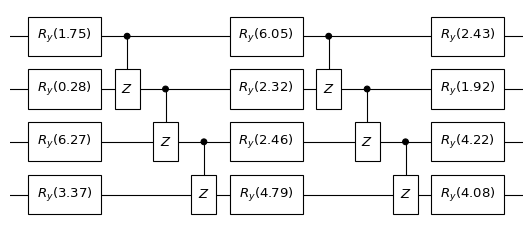

In [5]:
from paddle_quantum.qchem import HardwareEfficient

mol.build()
cir = HardwareEfficient(mol.num_qubits, depth=2)
cir.plot()

### Computing potential energy curve for hydrogen molecule
Next we will demostrate the usage of VQE method by calculating the potential energy curve of hydrogen molecule. Potential energy surface depicts the variation of molecular energy with respect to the position of inner atoms, it is widely used in physics and chemistry to find the optimal molecular structure or calculate the chemical reaction rate. For hydrogen molecule, the potential energy surface becomes a curve since hydrogen molecule only has one spatial degree of freedom (the distance between two hydrogen atoms).

In [9]:
import numpy as np
import paddle
from paddle.optimizer import Adam
from paddle_quantum.qchem import GroundStateSolver
from paddle_quantum.qchem import dipole_moment

paddle.seed(124)

cir_depth = 2
bond_lengthes = [0.1, 0.3, 0.5, 0.74, 0.9, 1.0, 1.5, 2.0]
energies = []
dipole_moments = []
for bond_len in bond_lengthes:
    mol = Molecule(
        geometry = [("H", [0.0, 0.0, 0.0]), ("H", [0.0, 0.0, bond_len])],
        driver = PySCFDriver()
    )
    mol.build()
    
    cir = HardwareEfficient(mol.num_qubits, cir_depth)

    solver = GroundStateSolver(Adam, num_iterations=100, tol=1e-5)
    e, psi = solver.solve(mol, cir, learning_rate=0.5)
    energies.append(e)

    # calculate dipole moments
    d = dipole_moment(psi, mol)
    dipole_moments.append(np.linalg.norm(d))

converged SCF energy = 2.71588739329275
converged SCF energy = -0.593827758535727
converged SCF energy = -1.04299627454009
converged SCF energy = -1.11675930739643
converged SCF energy = -1.09191404102006
converged SCF energy = -1.06610864931794
converged SCF energy = -0.910873554594387
converged SCF energy = -0.783792654277353


In the first plot, we can see that the ground state energy of hydrogen molecule first decrease with the growth of the extension of two hydrogen atoms and then increase, the lowest ground state energy occurs at bond length equal to 0.74 Angstrom. In the second plot, we can see that hydrogen molecule is unpolarized, its dipole moment is approximately zero no matter how bond length varies.

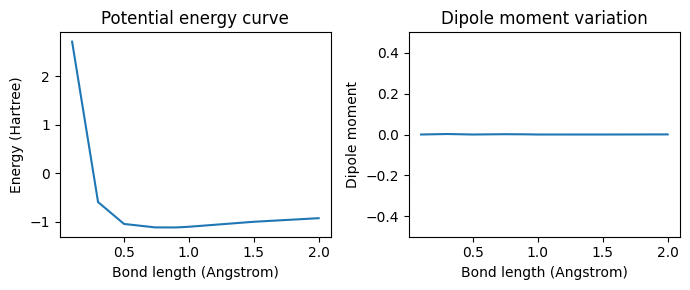

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 3), )
ax1 = fig.add_subplot(121)
ax1.plot(bond_lengthes, energies)
ax1.set_xlabel("Bond length (Angstrom)")
ax1.set_ylabel("Energy (Hartree)")
ax1.set_title("Potential energy curve")

ax2 = fig.add_subplot(122)
ax2.plot(bond_lengthes, dipole_moments)
ax2.set_xlabel("Bond length (Angstrom)")
ax2.set_ylabel("Dipole moment")
ax2.set_title("Dipole moment variation")
ax2.set_ylim(-0.5, 0.5)
fig.tight_layout()

## How to use
Users can edit the configuration file `config.toml` to customize the task, and the required settings are listed below.

```toml
# A description of the task of this configuration file, this is optional. "GroundState" stands for calculate the ground state energy of the molecule.

# This field stores information related to the molecule is provided.
[molecule]
# Symbols of atoms inside the molecule.
symbols = ['H', 'H']
# The cartesian coordinates of each atom inside the molecule.
coords = [ [ 0.0, 0.0, 0.0 ], [ 0.0, 0.0, 0.7 ] ]

# This field specifies configurations related to the quantum circuit in VQE is specified.
[ansatz.HardwareEfficient]
# The depth of the HardwareEfficient ansatz.
depth = 2

# This field stores configurations of the variational quantum eigensolver (VQE) method. 
[VQE]
# Number of optimization cycles, default is 100.
num_iterations = 100
```
After setup the configuration file, user can run the following command to perform the quantum chemistry task.
```shell
python energy_material.py --config example.toml
```

## Reference 
\[1\] [Thermaldynamic free energy](https://en.wikipedia.org/wiki/Thermodynamic_free_energy)

\[2\] Aydinol, M. K., et al. "Ab initio study of lithium intercalation in metal oxides and metal dichalcogenides." Physical Review B 56.3 (1997): 1354.

\[3\] Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." Nature 549.7671 (2017): 242-246.